In [1]:
import time
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import levy_stable
import tensorflow as tf

import bayesflow as bf

2024-05-24 13:54:38.887223: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-24 13:54:39.092620: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-24 13:54:39.092648: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-24 13:54:39.128640: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-24 13:54:39.189703: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Suppress scientific notation for floats
np.set_printoptions(suppress=True)

print(tf.__version__)

# Get rid of annoying tf warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

2.15.1


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-05-24 13:54:41.192579: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Num GPUs Available:  1


2024-05-24 13:54:41.296655: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-24 13:54:41.296701: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [4]:
def simulate_levy_trial(a=1, z=0.5, v=0, t=0.2, alpha=2.0, dt=0.001):
    """
    Simulates the response time for one trial from a Lévy-Flight Process
     * param a:     threshold separation (a>0)
     * param z:     relative Starting Point (0<z<1)
     * param v:     drift
     * param t:     non-decisio-time (t>0)
     * param alpha: stability parameter (0<a<2)
     * param dt:    step size for simulation (dt>0)
    
    The function returns a simulated response time. A negative sign indicates a response at the lower threshold
    """
    
    scale = np.power(dt,(1/alpha)) / np.sqrt(2)
    
    bin_size = np.int_(1/dt)  # The decision path is simulated in bins of 1 second
    start = [a*z]
    cnt = 0

    while(True):
        path = np.array(start + np.cumsum(v*dt + levy_stable.rvs(alpha, 0, scale=scale, size=bin_size)))
        if np.any(path < 0): 
            cnt = cnt + np.min(np.where(path < 0))
            return (-(t + cnt*dt)).astype(np.float32)
        
        if np.any(path > a): 
            cnt = cnt + np.min(np.where(path > a))
            return (t + cnt*dt).astype(np.float32)
        
        start = path[-1]
        cnt = cnt + bin_size

In [5]:
RNG = np.random.default_rng(2024)

In [6]:
def LF_prior():
    """
    Draws one set of marginally informative priors for the 7-parameter Levy-Flight-Model
    v1 nad v2 represent drift rates for two different stimulus types, 
    with positive and negative average slopes of evidence accumulation, respectively.
    
    The function returns a np array with all parameter values
    """
    a      = RNG.gamma(3, 1/3) + 0.1
    z      = RNG.beta(5, 5)
    v      = RNG.normal(3, 3) 
    t0     = RNG.gamma(1, 1/6) + 0.1
    st0    = RNG.beta(1,2) * 2*t0
    alpha  = RNG.beta (6, 2) * 2

    return np.array([a, z, v, t0, st0, alpha]).astype(np.float32)

In [7]:
PARAM_NAMES = ['a', 'z', 'v', 't', 'st', 'alpha']

In [8]:
prior = bf.simulation.Prior(prior_fun=LF_prior, param_names=PARAM_NAMES)

In [9]:
def LF_experiment(theta, n_obs=300):
    """
    Simulates response times for one participant of a lévy-flight experiment.
     * param theta: numpy array with the parameters of the lfm (a,z,v,t,st,alpha) 
     * param n_obs: (maximum) number of observations
    
    The function returns a 2 by n_obs array, where the first column give the stimulus type (0,1)
    and the second column gives the response times (negative values indicate responese at the lower threshold)
    """
    sim_data = np.zeros([n_obs,2])
    cnd = np.zeros(n_obs)
    sim_data[:,0] = cnd
    for i in range(n_obs):
        sim_data[i,1] = simulate_levy_trial(
                            a = theta[0], 
                            z = theta[1],
                            v = theta[2],
                            t = np.random.uniform(theta[3] - theta[4]/2, theta[3] + theta[4]/2), 
                            alpha = theta[5]
                        )   
    return sim_data.astype(np.float32)

In [10]:
simulator = bf.simulation.Simulator(simulator_fun = LF_experiment)
model = bf.simulation.GenerativeModel(prior=prior, simulator=simulator, name="lfm")

INFO:root:Performing 2 pilot runs with the lfm model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 6)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 300, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [11]:
summary_net = bf.networks.SetTransformer(input_dim=2, summary_dim=12, name="lfm_summary")

2024-05-24 13:54:41.541468: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-24 13:54:41.541545: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-24 13:54:41.541563: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-24 13:54:41.669328: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-24 13:54:41.669384: I external/local_xla/xla/stream_executor

In [12]:
inference_net = bf.networks.InvertibleNetwork(
    num_params=len(prior.param_names),
    coupling_settings={"dense_args": dict(kernel_regularizer=None), "dropout": False},
    name="lfm_inference",
)

In [13]:
amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net, name="lfm_amortizer")

In [14]:
prior_means, prior_stds = prior.estimate_means_and_stds(n_draws=100000)
prior_means = np.round(prior_means, decimals=1)
prior_stds = np.round(prior_stds, decimals=1)
print(prior_means, prior_stds)

[[1.1 0.5 3.  0.3 0.2 1.5]] [[0.6 0.2 3.  0.2 0.2 0.3]]


In [15]:
#prior_means = [ 1.1,  0.5,  3.,  -3.,   0.3,  0.2,  1.5]
#prior_stds = [0.6, 0.2, 3.,  3.,  0.2, 0.2, 0.3]

In [16]:
def configurator(forward_dict, min_trials=275, max_trials=300):
    """Configure the output of the GenerativeModel for a BayesFlow setup."""

    # Prepare placeholder dict
    out_dict = {}

    # Extract simulated response times
    data = forward_dict["sim_data"]
    num_trials = np.random.randint(min_trials, max_trials + 1)
    idx = np.random.choice(range(data.shape[1]), size=num_trials, replace=False)
    data = data[:, idx, :]

    out_dict["summary_conditions"] = data.astype(np.float32)


    # Make inference network aware of varying numbers of trials
    # We create a vector of shape (batch_size, 1) by repeating the sqrt(num_obs)
    vec_num_obs = np.sqrt(num_trials) * np.ones((data.shape[0], 1))
    out_dict["direct_conditions"] = np.sqrt(vec_num_obs).astype(np.float32)

    # Get data generating parameters
    params = forward_dict["prior_draws"].astype(np.float32)

    # Standardize parameters
    out_dict["parameters"] = ((params - prior_means) / prior_stds).astype(np.float32)

    return out_dict

In [17]:
trainer = bf.trainers.Trainer(
    generative_model=model, 
    amortizer=amortizer, 
    configurator=configurator,
    default_lr=0.0001,
    checkpoint_path="checkpoints//lfm_intelligence"
)

INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with provided components...
2024-05-24 13:54:42.990562: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
INFO:root:Done.


In [19]:
%%time
## Attention: Takes about 5 minutes per 1,000 data sets!
## For training, at least 100,000 data sets are recommended (~16 hours)

train_data = model(100000)

f = open("training_data_lfm.obj","wb")
pickle.dump(train_data,f,protocol=4)
f.close()

CPU times: user 2h 17min 5s, sys: 979 ms, total: 2h 17min 6s
Wall time: 2h 17min 5s


In [18]:
f = open("training_data_lfm.obj","rb")
train_data  = pickle.load(f)
f.close()


In [20]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [21]:
history = trainer.train_offline(
    simulations_dict = train_data, 
    epochs = 1000, 
    batch_size = 20
)  

TypeError: `tf.data.Dataset` only supports `len` in eager mode. Use `tf.data.Dataset.cardinality()` instead.

In [ ]:
#history = trainer.train_online(
#    epochs = 100, # 100
#    iterations_per_epoch = 100, # 100
#    batch_size = 16
#)  

Training epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

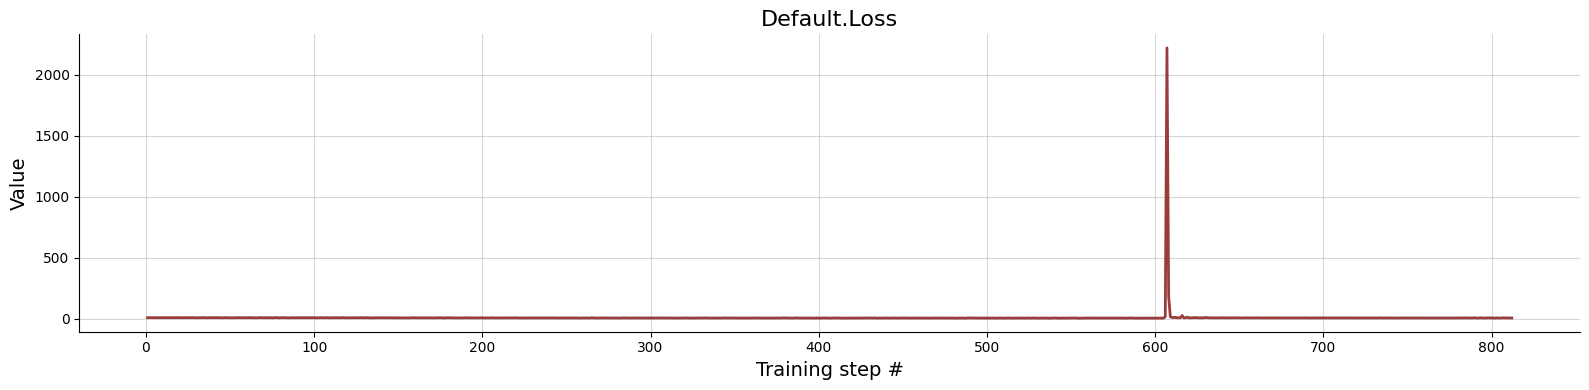

In [ ]:
f = bf.diagnostics.plot_losses(history)

In [ ]:
# Generate some validation data
validation_sims = configurator(model(batch_size=100))

# Extract unstandardized prior draws and transform to original scale
prior_samples = validation_sims["parameters"]


In [ ]:
print(
    f"Estimation will be performed on data sets with {validation_sims['summary_conditions'].shape[1]} simulated trials."
)


Estimation will be performed on data sets with 253 simulated trials.


In [ ]:
# Generate 100 posterior draws for each of the 1000 simulated data sets
post_samples = amortizer.sample(validation_sims, n_samples=100)

# Unstandardize posterior draws into original scale
post_samples = post_samples 

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 1.                    Confidence intervals might be unreliable!


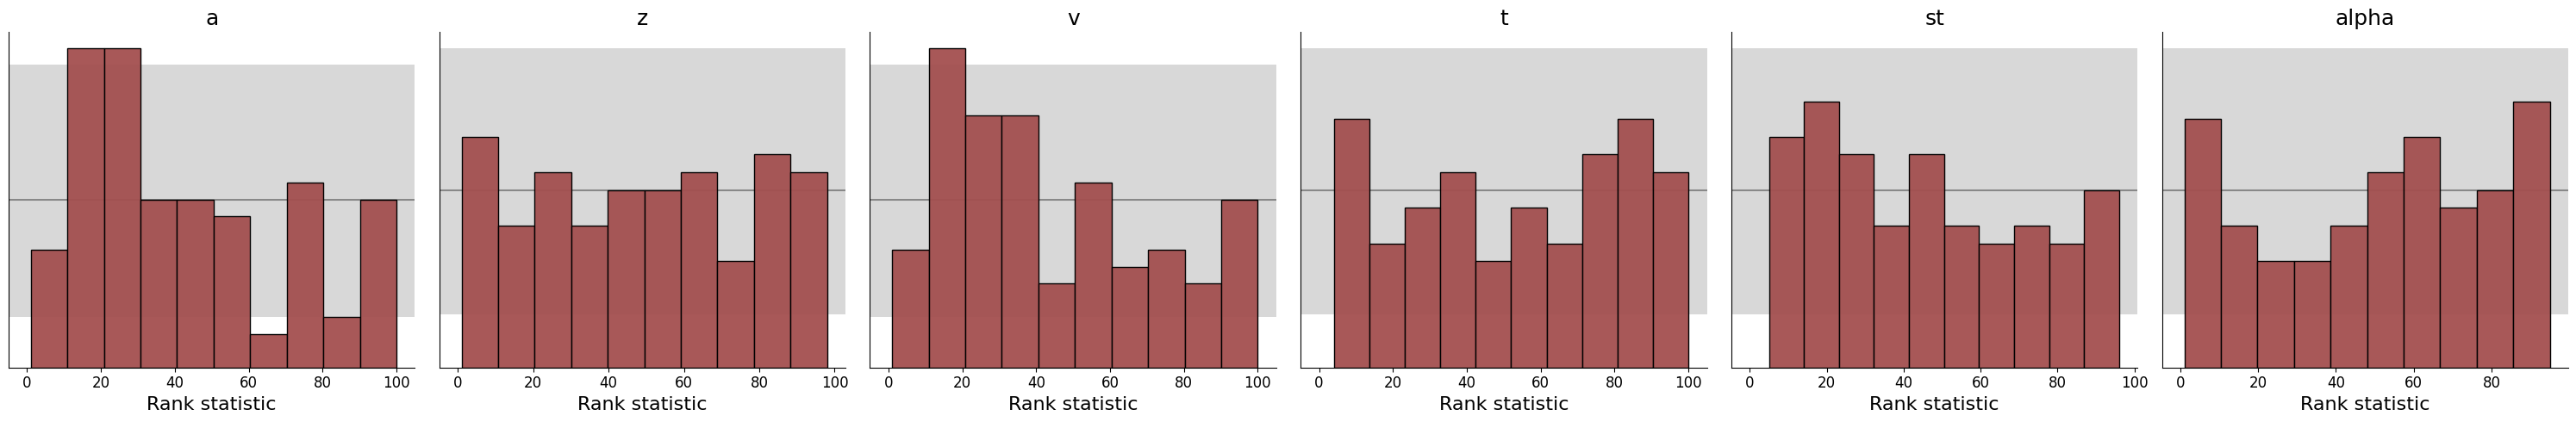

In [ ]:
f = bf.diagnostics.plot_sbc_histograms(post_samples, prior_samples, num_bins=10, param_names=PARAM_NAMES)

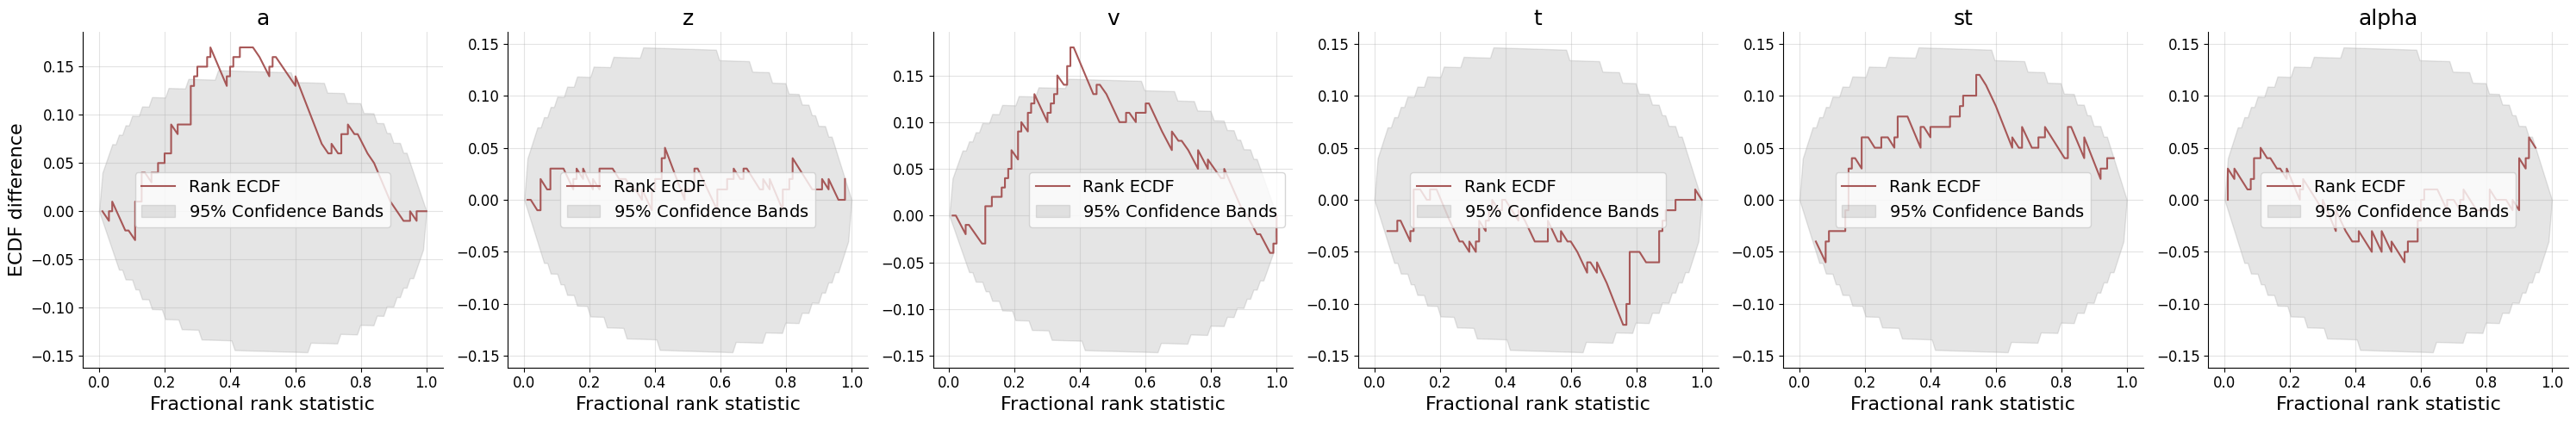

In [ ]:
f = bf.diagnostics.plot_sbc_ecdf(post_samples, prior_samples, stacked=False, difference=True, param_names=PARAM_NAMES)

In [ ]:
post_samples = amortizer.sample(validation_sims, n_samples=1000)


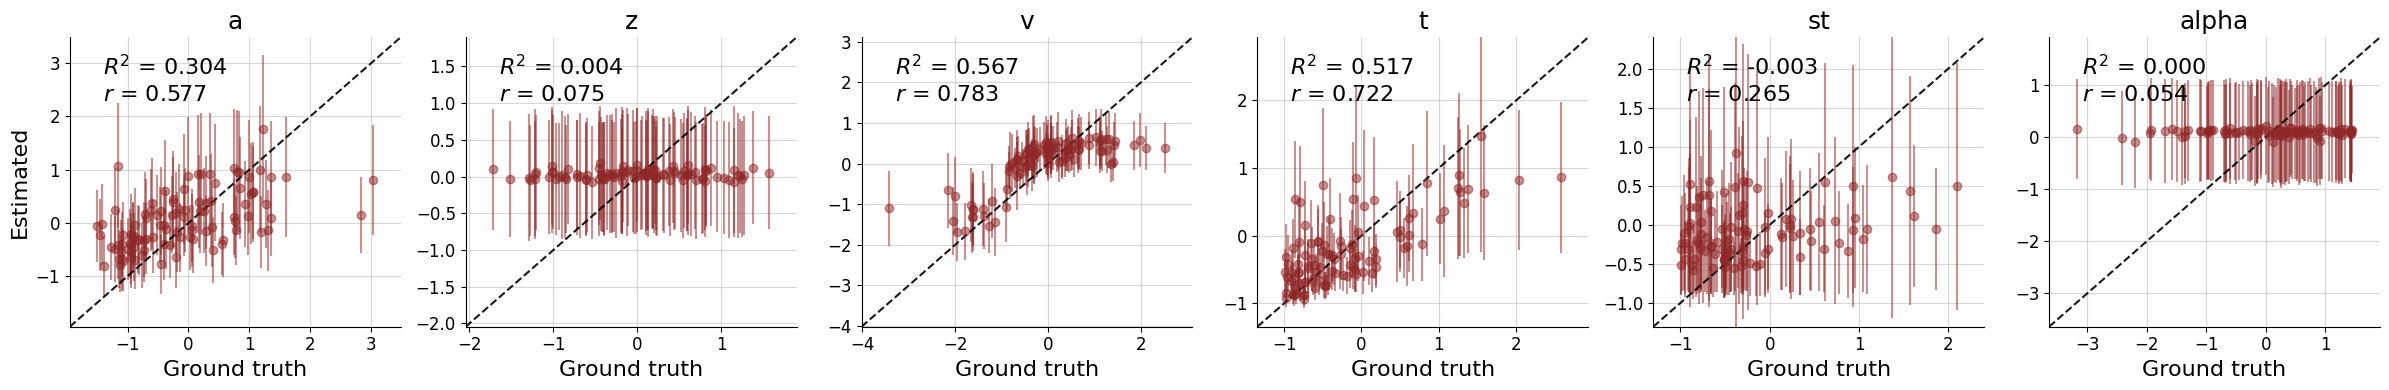

In [ ]:
f = bf.diagnostics.plot_recovery(
    post_samples, prior_samples, param_names=prior.param_names, point_agg=np.mean, uncertainty_agg=np.std
)

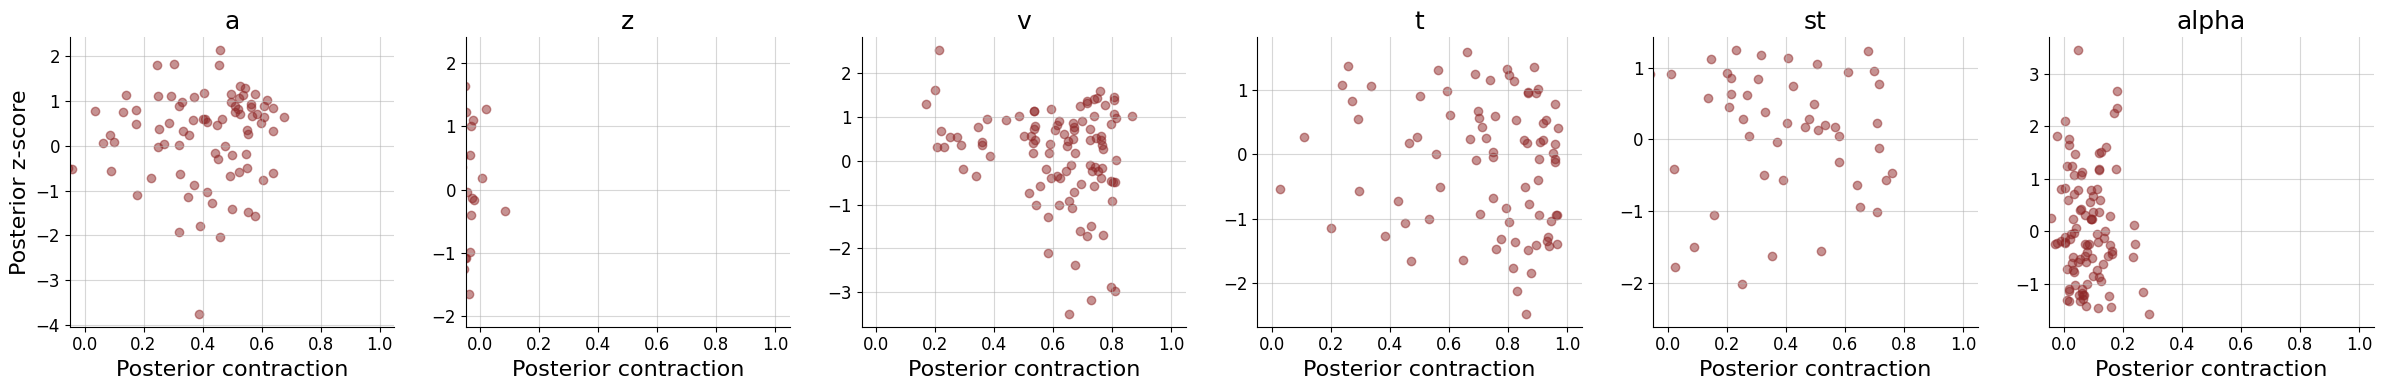

In [ ]:
f = bf.diagnostics.plot_z_score_contraction(post_samples, prior_samples, param_names=prior.param_names)